In [96]:
import pandas as pd
import numpy as np
import re

# url = 'https://github.com/JeffSackmann/tennis_atp/blob/aade0d19524855adb4d65782f5eec495fb8479d6/atp_matches_2023.csv'
url = 'atp_matches_2023.csv'

df = pd.read_csv(url)

# encode counties as binary
countries_encoded = pd.get_dummies(df[['winner_ioc', 'loser_ioc']])

#create unique match ID
df['match_id'] = df['tourney_id'].astype(str) + '-' + df['match_num'].astype(str)

df = df[df.tourney_level != 'D'] # exclude Davis Cup
df.sort_values(by=['tourney_date', 'tourney_id', 'match_num'], inplace=True)
df.groupby(['winner_id']).cumcount().add(1) 
df.columns

In [ ]:
# Check the versions of libraries

# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

In [217]:
metadata = df[list(filter(re.compile('.*name').match, df.columns))]
# match_pre_data = np.array()
matchplay_stats = df[list(filter(re.compile('^w_|^l_|match_id').match, df.columns))]
# col_types = np.array()

In [220]:
# for each predictor, calculate the difference between the winner and loser value, and append it to new df

num_preds = len(list(filter(re.compile('w_').match, df.columns)))

matchplay_stats_agg = pd.DataFrame()
for i in np.arange(num_preds):
    matchplay_stats_agg[i] = matchplay_stats.iloc[:,i] - matchplay_stats.iloc[:,i + num_preds]
    
# matchplay_stats_agg['match_id'] = matchplay_stats.iloc[:,-1]

In [221]:
matchplay_stats_agg

,0,1,2,3,4,5,6,7,8
105,5.0,1.0,-2.0,-8.0,2.0,5.0,0.0,1.0,-1.0
104,7.0,-1.0,-19.0,-6.0,3.0,-6.0,0.0,-2.0,-4.0
103,10.0,-2.0,-14.0,-7.0,2.0,2.0,0.0,-2.0,-5.0
102,0.0,-1.0,-6.0,-10.0,2.0,10.0,1.0,-1.0,-5.0
101,3.0,1.0,-10.0,-8.0,1.0,2.0,0.0,-4.0,-7.0
...,...,...,...,...,...,...,...,...,...
1545,0.0,-1.0,-20.0,-13.0,-2.0,3.0,0.0,0.0,-3.0
1544,2.0,-4.0,-15.0,-5.0,0.0,2.0,0.0,-4.0,-7.0
1543,2.0,4.0,7.0,15.0,8.0,-7.0,1.0,0.0,0.0
1542,1.0,0.0,-1.0,-4.0,2.0,0.0,0.0,-1.0,-2.0


In [222]:
num_rows = len(matchplay_stats_agg)
half_num_rows = round(num_rows * 0.5)
matchplay_stats_agg['winner'] = ([1] * half_num_rows) + ([0] * (num_rows - half_num_rows)) # first half of matches, to be left alone, and coded as won by first player
matchplay_stats_agg.iloc[half_num_rows:num_rows] *= -1 # second half, to be reversed, and coded as won by second player

In [223]:
matchplay_stats_agg

,0,1,2,3,4,5,6,7,8,winner
105,5.0,1.0,-2.0,-8.0,2.0,5.0,0.0,1.0,-1.0,1
104,7.0,-1.0,-19.0,-6.0,3.0,-6.0,0.0,-2.0,-4.0,1
103,10.0,-2.0,-14.0,-7.0,2.0,2.0,0.0,-2.0,-5.0,1
102,0.0,-1.0,-6.0,-10.0,2.0,10.0,1.0,-1.0,-5.0,1
101,3.0,1.0,-10.0,-8.0,1.0,2.0,0.0,-4.0,-7.0,1
...,...,...,...,...,...,...,...,...,...,...
1545,-0.0,1.0,20.0,13.0,2.0,-3.0,-0.0,-0.0,3.0,0
1544,-2.0,4.0,15.0,5.0,-0.0,-2.0,-0.0,4.0,7.0,0
1543,-2.0,-4.0,-7.0,-15.0,-8.0,7.0,-1.0,-0.0,-0.0,0
1542,-1.0,-0.0,1.0,4.0,-2.0,-0.0,-0.0,1.0,2.0,0


In [277]:
matchplay_stats_agg = matchplay_stats_agg.dropna()

LR: 0.947019 (0.020676)
LDA: 0.947813 (0.019133)
KNN: 0.914611 (0.029351)
CART: 0.874316 (0.031250)
NB: 0.861636 (0.030353)
SVM: 0.773091 (0.031988)


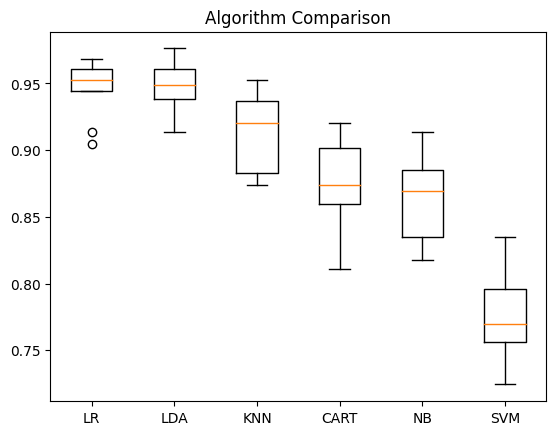

In [278]:
# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:9]
y = array[:,9]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [281]:
# make predictions
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# Load dataset

# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:9]
y = array[:,9]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9684542586750788
[[147   8]
 [  2 160]]
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       155
         1.0       0.95      0.99      0.97       162

    accuracy                           0.97       317
   macro avg       0.97      0.97      0.97       317
weighted avg       0.97      0.97      0.97       317

